# Problem 1. Symbolic computations

1) [75%] Find local maxima (and only maxima!) (x and f(x)) for this function using symbolic computations library in Python (e.g. sympy):

       f(x) = x7 - 10x6 + 42x5 + 128x4 - 800x3 + 1300x2 - 670x


2) [25%] Visualize the result as a graph, and show maxima points.

In [1]:
from sympy.parsing.sympy_parser import (parse_expr, standard_transformations, implicit_multiplication, function_exponentiation)
from sympy import (symbols, diff, Eq, solveset, S)
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Initial string
string = 'f(x) = x^7 - 10x^6 + 42x^5 + 128x^4 - 800x^3 + 1300x^2 - 670x'

In [3]:
# Replacing exponents with correct ones for sympy
expression = string.replace('^', '**').split('=')[1]

In [4]:
transformations = (standard_transformations + (implicit_multiplication, function_exponentiation))
# Parsing expression
eq = parse_expr(expression, transformations=transformations)
# Making x symbol
x = symbols('x')
# Calculating derivatives
der1 = diff(eq, x)
der2 = diff(der1, x)
# Getting roots of the first derivative
roots = solveset(der1, x, domain=S.Reals)
roots = [r.evalf() for r in roots]
# Second derivative test
maxima = list(filter(lambda r: der2.subs(x, r) < 0, roots))
y_maxima = [eq.subs(x, r) for r in maxima]

print(f'Local maxima: {y_maxima}')
print(maxima)

Local maxima: [26831.6312449036]
[-3.21685608208763]


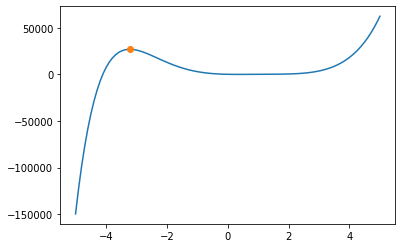

In [5]:
t = np.linspace(-5, 5, 100)
y = [eq.subs(x, ti) for ti in t]
plt.plot(t, y)
plt.plot(maxima, y_maxima, marker='o')
plt.show()

# Problem 2. Solving

[75%] Implement text interface (bot), which can solve computational problems, equation solving and differential equation solving. The bot should return relevant answers with respect to the task (number for computations and equations, functions for differential equations).
1) [25%] type of: 34 * 45  ——> 1530
2) [25%] type of: 2*x^2 + 4x + 2 = 0 ——> -1
3) [25%] type of: f’ = cos(x) ——> f = sin(x) + C

- [23%] When result is the function — plot the graph.
- [2%] For equation solving (if possible) do the plot (intersection of 2 graphs)

In [1]:
import requests
from bs4 import BeautifulSoup
import re
from sympy.parsing.sympy_parser import (parse_expr, standard_transformations, implicit_multiplication, function_exponentiation)
from sympy import (symbols, diff, Eq, solveset, S)
import numpy as np
from matplotlib import pyplot as plt

# 1. register at https://www.wolframalpha.com/
# 2. Get App ID at http://developer.wolframalpha.com/portal/myapps/
APP_NAME = "Lab3"
APPID = open("wa.app.id").read()
API = "http://api.wolframalpha.com/v2/query?input={}&appid={}"

In [2]:
class Solver():
    def __init__(self):
        # Initializing the 
        self.APP_NAME = "Lab3"
        self.APPID = open("wa.app.id").read()
        self.API = "http://api.wolframalpha.com/v2/query?input={}&appid={}"
        self.transformations = (standard_transformations + (implicit_multiplication, function_exponentiation))
    
    def solve(self, equation):
        if ('\'' in equation) or ('’' in equation):
            return self.solve_de(equation)
        else:
            if re.findall('[a-z]+', equation):
                return self.solve_eq(equation)
            else:
                return self.calculate(equation)
    
    def calculate(self, equation):
        '''
        equation: str the equation to calculate
        '''   
        # Preprocessing expression
        expr = self.preprocess(equation)
        
        # Parsing it to sympy
        eq = parse_expr(expr, transformations=self.transformations)
        
        # Evaluating
        return eq.evalf()
        
    def solve_eq(self, equation):
        '''
        equation: str the equation to solve
        '''       
        # Preprocessing
        expr = self.preprocess(equation)
        
        # carry with the '-' sign
        expr = expr.split('=')
        expr = expr[0] + f'-({expr[1]})'
        
        # Finding variable names
        variable = self.find_variable(expr)
        
        if variable == None:
            return None
        
        # Parsing expression
        eq = parse_expr(expr, transformations=self.transformations)
        
        # Making symbol for the variable
        x = symbols(variable)
        
        # Roots
        roots = solveset(eq, x)
        
        # returning evaluated
        return [r.evalf() for r in roots]
    
    def solve_de(self, equation):
        
        # Getting result from Wolfram
        resp = requests.get(API.format(equation, APPID))
        
        # If status code is not 200
        if resp.status_code != 200:
            print("Something went wrong... Please, try again!")
            return None
        
        # Parsing the result
        dom = BeautifulSoup(resp.text, "lxml")
        
        # Finding solution section
        result = dom.queryresult.findAll("pod", id="Solution")
        
        # Extracting solution from the plaintext tag
        solution = result[0].plaintext.text
        
        self.plot_eq(solution)
        
        return solution
      
    def plot_eq(self, eq):
        
        # Getting the right side of equation
        equation = eq.split('=')[1]
        
        # Removing 'c_1 +' we got from using wolfram 
        equation = equation.split('+')[1:]
        equation = '+'.join(equation)
        
        # Preprocessing equation
        equation = self.preprocess(equation)
        
        # Finding variable names
        variable = self.find_variable(equation)
        
        if variable == None:
            return None
        
        # Making symbol for the variable
        x = symbols(variable)
        
        # Parsing expression
        eq = parse_expr(equation, transformations=self.transformations)
        
        # Generating points
        t = np.linspace(-5, 5, 100)
        y = [eq.subs(x, ti) for ti in t]
        
        # Plotting the result
        plt.plot(t, y)
        plt.show()
        
     
    def find_variable(self, expression):
        # Finding variable names
        variable = set(re.findall('[x-z]+',expression))
        
        # There can not be more than one variable
        if len(variable) != 1:
            print('Please, enter the equation of a single variable')
            return None
        
        # Getting variable string name
        variable = variable.pop()
        
        return variable
    
    def preprocess(self, eq):
        return eq.replace('^', '**')

Please, enter your equation:


 34*45


1530.00000000000
Please, enter your equation:


 2*x^2 + 4x + 2 = 0


[-1.00000000000000]
Please, enter your equation:


 f’ = cos(x)


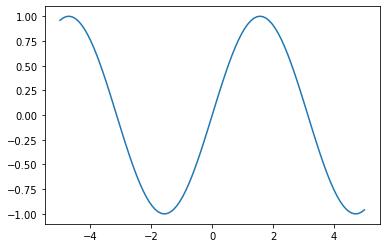

f(x) = c_1 + sin(x)
Please, enter your equation:


 exit


In [3]:
solver = Solver()

while True:
    print('Please, enter your equation:')
    equation = str(input())
    if equation == 'exit':
        break
    print(solver.solve(equation))

# Problem 3. Minimax

[75%] Implement a minimax tree for a simplified version of Halma. You are given 3x3 field and 3 pieces each:

You need to move pieces in the “Home” of your opponent (colored). Who finished first — wins. If you cannot finish in 16 moves — draw.

Moves are done into a spare neighbour cell (8-connectivity), OR by jumping over the piece (no matter, your or opponent’s). E.g. debuts like these are allowed:

 - A2-B2 ; C2-A2
 - A1-B2 ; C3-A1
 - B1-C1 ; C3-B2

[25%] Visualize the game which leads to WIN. OR implement a bot to play with.

In [1]:
import copy
import itertools
import numpy as np
import math

# Solution based on HW

class Field(object):
    # state is a 3x3 char matrix
    # Game pieces are going to be represented by:
    # 'x' - player 1's piece
    # 'o' - player 2's piece
    state = []
    turn = 0
    children = []
    minimax_score = None
    x_points = None
    o_points = None
    
    def __init__(self, state, turn):
        self.state = state
        self.turn = turn
        self.x_points = np.argwhere(np.array(state) == 'x')
        self.o_points = np.argwhere(np.array(state) == 'o')
        
    def __str__(self):
        '''
        this is a field representation code
        '''
        
        res = "  | A | B | C |\n-------------------\n"
        for i, line in enumerate(self.state):
            res += "{} | {} | {} | {} |\n".format(i+1, *line)
            res += "-------------------\n"
        return res
    
    def __repr__(self):
        '''
        this is a short form to represent a field
        '''
        return "".join(itertools.chain(*self.state)) + f'{self.turn}'
    
    def get(self, tpl):
        # Done
        '''
        returns a characted in a given position
        '''
        return self.state[tpl[0]][tpl[1]]
    
    def make_a_move(self, tpl):
        '''
        Makes a move and returns a new field
        '''
        who = self.is_move_of()
        state = copy.deepcopy(self.state)
        state[tpl[0]][tpl[1]] = ' '
        state[tpl[2]][tpl[3]] = who
        return Field(state, self.turn + 1)
    
    def is_move_of(self):
        '''
        returns a piece if move can be done and a None if game is over
        '''
        if self.is_win_of() is not None:
            return None
        
        return 'x' if self.turn % 2 == 0 else 'o'
    
    def is_win_of(self):
        '''
        Checks who is winning
        '''
        if (self.state[1][2] == self.state[2][1] == self.state[2][2] == 'x'):
            return 'x'
        if (self.state[0][0] == self.state[1][0] == self.state[0][1] == 'o'):
            return 'o'
        # Maximal depth
        if self.turn == 16:
            return ' '
        # if game is not over -> return None
        return None
    
    def get_next_move(self):
        '''
        Gets the best move for the bot
        '''
        max_score = 0
        best_ch = []
        for ch in self.children:
            if (ch.minimax_score > max_score):
                # in case of vizhu maat v 4 hoda, a ne v 1
                if (ch.is_win_of() == 'x'):
                    return ch
                max_score = ch.minimax_score
                best_ch = [ch]
            if (ch.minimax_score == max_score):
                best_ch.append(ch)
        return np.random.choice(best_ch)

In [2]:
def is_possible_move(field, side, start, end, debug=False):
    '''
    Checks if move is possible
    '''
    # Checking if every element in start and end does not exceed boundaries
    # Of the board
    if not all([m <= 2 and m >= 0 for m in np.append(start, end)]):
        return False
    # Field must be empty
    if field.state[end[0]][end[1]] != ' ':
        return False
    # Checking for the move through two cells
    dx = (end[0] - start[0])
    dy = (end[1] - start[1])
    middle_x = int(math.copysign(abs(dx) // 2, dx)) + start[0]
    middle_y = int(math.copysign(abs(dy) // 2, dy)) + start[1]
    # If change was only for one cell, dx=dy=0, cell[start]==cell[start+0]
    # If change was in two cells, dx and dy will give the coordinates of the between cell
    if (field.state[middle_x][middle_y] == ' '):
        return False
    return True

def get_move_tuple(notation, field):
    '''
    Converts notation like 'c1c2' into a tuple (2, 0, 2, 1)
    '''
    notation = notation.lower()
    if len(notation) != 4:
        return None
    if (notation[0] not in 'abc') or (notation[1] not in '123') or (notation[2] not in 'abc') or (notation[3] not in '123'):
        return None
    translation = {'a': 0, 'b': 1, 'c': 2,}
    start, end = [int(notation[1]) - 1, translation[notation[0]]], [int(notation[3]) - 1, translation[notation[2]]]
    if is_possible_move(field, 'o', start, end, True):
        return (start[0], start[1], end[0], end[1])
    return None

In [3]:
import copy
    
def generate_children_for_the_field(field):
    '''
    Generates children for the field
    '''
    result = []
    # Singular moves
    movements = [np.array([1, 0]), np.array([-1, 0]), np.array([0, 1]), np.array([0, -1]), np.array([1, 1]), np.array([-1, 1]), np.array([1, -1]), np.array([-1, -1])]
    # Double moves
    movements.extend((np.array(movements) * 2))
    if field.is_win_of() is None:
        who_moves = field.is_move_of()
        points = field.x_points if who_moves == 'x' else field.o_points
        for p in points:
            for m in movements:
                new_p = p+m
                if is_possible_move(field, who_moves, p, new_p):
                    state = copy.deepcopy(field.state)
                    state[p[0]][p[1]] = ' '
                    state[new_p[0]][new_p[1]] = who_moves
                    child = Field(state, field.turn + 1)
                    result.append(child)
    field.children = result
    return result

In [4]:
def update_minimax(field):
    '''
    Updates minimax
    If the state is not terminal but there it is max depth
    assigns a 0
    Win - 1
    lose - -1
    Draw - 0.5
    '''
    field.minimax_score = 0
    win = field.is_win_of()
    if win != None:
        if win == 'x':
            field.minimax_score = 1
        if win == 'o':
            field.minimax_score = -1
        if win == ' ':
            # Fixes depth
            field.minimax_score = 0.5
    else:
        side = field.is_move_of()
        scores = []
        for ch in field.children:
            update_minimax(ch)
            scores.append(ch.minimax_score)
        if not scores:
            field.minimax_score = 0
        else:
            if side == 'x':
                field.minimax_score = max(scores)
            else:
                field.minimax_score = min(scores)
    return field.minimax_score

In [5]:
# generate a tree
# store it as a map {str -> Field}
def generate_tree(initial, depth=5, debug=False):
    '''
    Generates a tree to some depth
    '''
    states = {initial.__repr__(): initial}
    queue = [(initial, 0)]
    while queue:
        curr = queue.pop()
        children = generate_children_for_the_field(curr[0])
        for child in children:
            states[child.__repr__()] = child
            if depth > curr[1]:
                queue.append((child, curr[1]+1))
    update_minimax(initial)
    if debug:
        print('Total states:', len(states))
        ## BTW, is this ok that some nodes in a tree have the same repr?
        print("Root score: ", initial.minimax_score)
    
    return states

In [6]:
from IPython.display import clear_output

state0 = [['x', 'x', ' '], ['x', ' ', 'o'], [' ', 'o', 'o']]
initial = Field(state0, 0)

field = initial
while field.is_win_of() is None:
    states = generate_tree(field)
    # make a bot move
    field = field.get_next_move()
    # show it
    print(field)
    # if bot wins
    if field.is_win_of() is not None:
        break
    # ask for a move
    m = input("Your move:")
    tpl = get_move_tuple(m, field)
    while tpl is None:
        print("Provide something like `b3b2` of an empty field")
        m = input("Your move:")
        tpl = get_move_tuple(m, field)
    # first build a representation, then retrieve a field from the tree
    field = states[field.make_a_move(tpl).__repr__()]

vic = field.is_win_of()
    
if vic == ' ':
    print('Draw')
else:
    print(field.is_win_of(), "wins")

  | A | B | C |
-------------------
1 | x | x |   |
-------------------
2 |   | x | o |
-------------------
3 |   | o | o |
-------------------



Your move: c2c1


  | A | B | C |
-------------------
1 |   | x | o |
-------------------
2 | x | x |   |
-------------------
3 |   | o | o |
-------------------



Your move: c1a1


  | A | B | C |
-------------------
1 | o | x |   |
-------------------
2 |   | x | x |
-------------------
3 |   | o | o |
-------------------



Your move: b3a2


  | A | B | C |
-------------------
1 | o | x |   |
-------------------
2 | o |   | x |
-------------------
3 |   | x | o |
-------------------



Your move: c3b2


  | A | B | C |
-------------------
1 | o | x |   |
-------------------
2 | o | o |   |
-------------------
3 |   | x | x |
-------------------



Your move: b2c1


  | A | B | C |
-------------------
1 | o |   | o |
-------------------
2 | o |   | x |
-------------------
3 |   | x | x |
-------------------

x wins


# Problem 4. Syntax
1) [75%] Create a language syntax (context-free grammar) which recognizes the following sentences, describing relations:
  - Moscow is far from Voronezh.

  - Kazan is far from Voronezh.

  - Kazan is far from Moscow.

  - Innopolis is close to Kazan.

  - Dolgoprudnyy is close to Moscow.

  - NizhniyNovgorod is equidistant to Moscow and Kazan.

  - Bor is close to NizhniyNovgorod.

  - Tula is equidistant to Moscow and Voronezh.

  - SaintPetersburg is far from Moscow.

  - Bologoe is equidistant to Moscow and SaintPetersburg.

  - Vyborg is close SaintPetersburg.

  - Zaymishche is equidistant to Innopolis and Kazan.


Let “far from” be 10, “close to” = 1, and “equidistant to” splits the existing edge into equal edges and transit vertex. Process sentences from the example and store information in the adjacency matrix.


2) [25%] Visualize the graph using networkx using spring layout. Is it similar to the real map?

In [1]:
from lark import Lark
from collections import defaultdict
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

## Calculating matrix

In [2]:
class Field():
    def __init__(self):
        self.matrix = np.array([])
        self.labels = defaultdict(lambda: -1)
        self.parser = Lark(r"""
            ?value: far
                  | close
                  | equidistant

            far: city "is far from" city "." "\n"*
            close: city "is close to" city "."* "\n"*
            equidistant: city "is equidistant to" city "and" city "."* "\n"*
            city: WORD

            %import common.WORD
            %ignore " "
        """, start='value')
        
    def parse(self, string):
        tree = self.parser.parse(string)
        if tree.data == 'far':
            self.parse_fc(tree, 'far')
        if tree.data == 'close':
            self.parse_fc(tree, 'close')
        if tree.data == 'equidistant':
            self.parse_eq(tree)
            
    def parse_fc(self, tree, mode):
        city1 = tree.children[0].children[0].title()
        city2 = tree.children[1].children[0].title()
        idx1 = self.preprocess(city1)
        idx2 = self.preprocess(city2)
        cost = 10 if mode == 'far' else 1
        self.set_cost(idx1, idx2, cost)
        
    def parse_eq(self, tree):
        city_b = tree.children[0].children[0].title()
        city1 = tree.children[1].children[0].title()
        city2 = tree.children[2].children[0].title()
        idx1 = self.preprocess(city1)
        idx2 = self.preprocess(city2)
        if (self.labels[city1] == -1) or (self.labels[city2] == -1) or (self.matrix[idx1][idx2] == 0):
            print('No such edge on the graph!')
        else:
            idx_b = self.preprocess(city_b)
            cost = self.matrix[idx1][idx2] / 2
            self.set_cost(idx1, idx2, 0)
            self.set_cost(idx1, idx_b, cost)
            self.set_cost(idx2, idx_b, cost)
            
    def preprocess(self, city):
        idx = self.labels[city]
        if idx == -1:
            self.matrix = self.extend_matrix()
            self.labels[city] = len(self.labels)-1
            return self.labels[city]
        return idx
    
    def extend_matrix(self):
        sh = self.matrix.shape[0]
        result = np.zeros((sh + 1, sh + 1))
        for i in range(sh):
            for j in range(sh):
                result[i][j] = self.matrix[i][j]
        return result
        
    def set_cost(self, idx1, idx2, cost):
        self.matrix[idx1][idx2] = cost
        self.matrix[idx2][idx1] = cost

In [3]:
f = Field()
with open('input.txt', 'r+') as inp:
    lines = inp.readlines()

for line in lines:
    f.parse(line)

## Drawing graph

In [4]:
graph = nx.from_numpy_array(f.matrix)
# https://stackoverflow.com/questions/52483678/python-networkx-edges-based-on-indices
mapping = {idx:name for idx, name in enumerate(f.labels)}
graph = nx.relabel_nodes(graph, mapping)

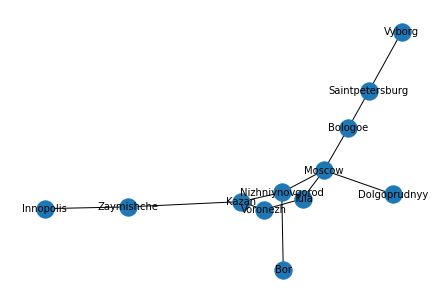

In [5]:
# https://www.programcreek.com/python/example/89544/networkx.spring_layout
pos = nx.drawing.layout.spring_layout(graph)
edge_labels = nx.get_edge_attributes(graph, 'label')
nx.draw(graph, pos)
nx.draw_networkx_labels(graph, pos, font_size=10)
plt.show() 

# Problem 5. Syntax tree

1) [75%] Alphabet is “0123456789()+-/*”. Using this alphabet you can build arithmetic formulas with a mandatory brace. Like this:
 - (1)
 - (2+3)
 - ((2-4)*(8/2))
        Write a syntax for this language. Restore AST.

2) [25%] Use the tree to compute the value of the formula.

In [1]:
from lark import Lark
import lark
from collections import defaultdict
import numpy as np

In [2]:
class AlphabetTree():
    def __init__(self):
        self.parser = Lark(r"""
            ?value: braces

            braces: "(" equation ")"
            equation: num (SIGN num)?
            num: NUMBER | braces
            NUMBER: ("0".."9")+
            SIGN: "+" | "-" | "/" | "*"
            
            %ignore " "
        """, start='value')
            
    def parse(self, string):
        return self.parser.parse(string) 
    
    def calculate(self, tree):
        br = tree.children[0]
        if len(br.children) == 1:
            num = tree.children[0].children[0]
            return self.calculate_num(num)
        else:
            num1 = br.children[0]
            sign = br.children[1].title()
            num2 = br.children[2]
            numb1 = self.calculate_num(num1)
            numb2 = self.calculate_num(num2)
            return self.calculate_expr(numb1, numb2, sign)
            
    def calculate_num(self, num):
        token = num.children[0]
        if type(token) == lark.lexer.Token:
            return int(token.title())
        else: 
            return self.calculate(token)
            
    def calculate_expr(self, num1, num2, sign):
        if sign == '+':
            return num1+num2
        if sign == '-':
            return num1-num2
        if sign == '/':
            return num1/num2
        if sign == '*':
            return num1*num2

In [3]:
equations = ['(1)', '(2+3)', '((2-4)*(8/2))']
a = AlphabetTree()

for idx, eq in enumerate(equations):
    print(f'Equation {idx}: {eq}')
    tree = a.parse(eq)
    print('Tree:')
    print(tree.pretty())
    print(f'Solution: {a.calculate(tree)}')
    print('----------------------------------------------')

Equation 0: (1)
Tree:
braces
  equation
    num	1

Solution: 1
----------------------------------------------
Equation 1: (2+3)
Tree:
braces
  equation
    num	2
    +
    num	3

Solution: 5
----------------------------------------------
Equation 2: ((2-4)*(8/2))
Tree:
braces
  equation
    num
      braces
        equation
          num	2
          -
          num	4
    *
    num
      braces
        equation
          num	8
          /
          num	2

Solution: -8.0
----------------------------------------------


# Problem 6. Music generation

1) [75%] Generate and play a major chord for a given note (A = 440 Hz).
- What is adding a semitone? Multiplying a note frequency by 21/12:
                440Hz + 1 semitone = 466.16Hz.
- What is a major chord? It consists of 3 notes: a given one (frequency N), N+(4 semitones), N+(7 semitones).
2) [25%] Add a minor chord (N, N+3, N+7) implementation.
- Play the melody “C G Am F G C”, where the capital letter corresponds to the note. Chord is major by default, “m” modifier means “minor” (Am = minor A chord). Note frequency reference is here (A=440, C=261.63, F=349.23, G=392.00). Each chord should last for 500ms.

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Audio

In [9]:
def generate_major(t, freq):
    time = np.linspace(0, t, int(fs * t))
    return np.array([np.sin(2*np.pi*freq*x) for x in time]) + np.array([np.sin(2*np.pi*freq*((2**(4/12)))*x) for x in time]) + np.array([np.sin(2*np.pi*freq*((2**(7/12)))*x) for x in time])

def generate_minor(t, freq):
    time = np.linspace(0, t, int(fs * t))
    return np.array([np.sin(2*np.pi*freq*x) for x in time]) + np.array([np.sin(2*np.pi*freq*((2**(3/12)))*x) for x in time]) + np.array([np.sin(2*np.pi*freq*((2**(7/12)))*x) for x in time])

In [10]:
# fs - industry standart 22050
fs = 24000
t = 5
a=440

sinus_major = generate_major(t, a)
sinus_minor = generate_minor(t, a)

In [11]:
Audio(sinus_major,rate=fs)

In [12]:
Audio(sinus_minor,rate=fs)

In [16]:
MAPPING = {'A': 440.0, 'B': 466.16, 'C': 261.63, 'D': 293.66, 'E': 329.63, 'F': 349.23, 'G': 392.0}

def generate_sequence(sequence):
    chords = sequence.split(' ')
    result = np.array([])
    for ch in chords:
        if len(ch) == 1:
            result = np.append(result, generate_major(0.5, MAPPING[ch]))
        else:
            result = np.append(result, generate_minor(0.5, MAPPING[ch[0]]))
    return result

In [18]:
seq = "Em Am B Em Dm"
signal = generate_sequence(seq)

Em
Am
Em
Dm


In [19]:
Audio(signal,rate=fs)

# Problem 7. Echo

1) [50%] Implement echo effect for a given audio file.
2) [50%] Implement two effect sliders (2 parameters) for both reflector distance and echo strength.

Echo - simple FIR filter with itself with delay

In [44]:
import numpy as np
import contextlib
import wave
from IPython.display import Audio

In [45]:
wave_file = "peterpiper.wav"
# Copied from the lab
wf = wave.open(wave_file, 'rb')
# byte representation ~ 200K bytes
data = wf.readframes(-1)
# Extracting FRAMES and RATE
with contextlib.closing(wf) as f:
    FRAMES = f.getnframes()
    RATE = f.getframerate()
    CHANNELS = f.getnchannels()
    DURATION = FRAMES / float(RATE)
    print("Rate: {}, frames: {}, channels: {}, time: {}".format(RATE, FRAMES, CHANNELS, DURATION))

Rate: 24000, frames: 107700, channels: 1, time: 4.4875


In [46]:
# Reference: https://publish.illinois.edu/augmentedlistening/tutorials/music-processing/tutorial-2-delay-based-effects/
def echo(audio, Fs, delay, strength):
    # Calculating delay idx based on frequency of the signal
    delay_idx = int(delay*Fs)
    # Initializing fir filter
    fir = np.zeros(delay_idx + 1)
    # Original wave
    fir[0] = 1
    # Plus delay operator
    fir[delay_idx] = strength
    # Convolving with wave
    res = np.convolve(audio, fir)
    return res

In [47]:
signal = np.frombuffer(data, np.int16)

In [49]:
#@title Parameters { run: "auto" }

# Delay in seconds
delay_t = 0.4 #@param {type:"slider", min:0.1, max:1.1, step:0.1}
# Strength of the echo
strength = 0.2 #@param {type:"slider", min:0.1, max:0.9, step:0.05}

signal_echo = echo(signal, RATE, delay_t, strength)
Audio(signal_echo,rate=RATE)

# Problem 9. Auto subtitles

In [29]:
!autosub origin-12.mp3

ffmpeg: Executable not found on machine.


Traceback (most recent call last):
  File "c:\users\pavel\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\pavel\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\pavel\AppData\Local\Programs\Python\Python38\Scripts\autosub.exe\__main__.py", line 7, in <module>
  File "c:\users\pavel\appdata\local\programs\python\python38\lib\site-packages\autosub\__init__.py", line 397, in main
    subtitle_file_path = generate_subtitles(
  File "c:\users\pavel\appdata\local\programs\python\python38\lib\site-packages\autosub\__init__.py", line 245, in generate_subtitles
    audio_filename, audio_rate = extract_audio(source_path)
  File "c:\users\pavel\appdata\local\programs\python\python38\lib\site-packages\autosub\__init__.py", line 185, in extract_audio
    raise Exception("Dependency not found: ffmpeg")
Exception: Dependency not

In [27]:
autosub

<module 'autosub' from 'c:\\users\\pavel\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\autosub\\__init__.py'>

# Problem 10. Classification

1) [75%] For a given image recognize the letters. Use whatever approach you like. I can suggest EMNIST or pytesseract.
2) [25%] Build words out of the letters. Try to fix typos using Norvig’s spell checker.

In [1]:
import pytesseract
import cv2
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20, 13) # (w, h)
import numpy as np

In [2]:
# Code from ICV Lab 3
def showInRow(list_of_images, titles = None):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
  plt.show()

In [3]:
# Code from ICV Lab 3
def getGaussKernel2d(ksize, sigma):
  kern = cv2.getGaussianKernel(ksize, sigma)
  return kern * np.transpose(kern)

In [4]:
def test_sigma(image, ker_size, alpha, max_sigma):
    # Testing for the best sigma
    # Prepearing kernels (form ICV Lab)
    kernels = list(map(lambda x: getGaussKernel2d(ker_size, x), range(1, max_sigma)))

    kernels_titles = list(map(lambda x: "Sigma "+str(x), range(1, max_sigma)))

    writings = list(map(lambda kern: cv2.filter2D(image, -1, kern), kernels))

    im_sharper = [image + alpha*(image-wr) for wr in writings]

    for idx, im in enumerate(im_sharper):
        print(f'{kernels_titles[idx]}: {pytesseract.image_to_string(im)}')


In [5]:
image = cv2.imread('PAI.png')
test_sigma(image, 30, 3, 10)

Sigma 1: Preeti cat. heck satel (telligence

Sigma 2: Prae | Lea Q Abd cial (teligence

Sigma 3: Practica Y be tibial Ttelligence

Sigma 4: Practical bdhiedel Ttelligence

Sigma 5: Prmelveat fetal Teli gence

Sigma 6:  

hbeiel Tiheligence

Sigma 7: Practical fttiecel Teligence

Sigma 8: Proetie f penal Tikeligence

Sigma 9: Proe } (ea t poche Tike ligence



We got pretty nice results for words Practical and Intelligence (Sigma=4, kernel_size=30, alpha=3), but word artificial still requires some processing:

In [6]:
artificial = image[:, 470:850]
test_sigma(artificial, 13, 4, 10)

Sigma 1: fic tocl waat

Sigma 2: 
Sigma 3: Ae L ‘ { és al

Sigma 4: Ihe . i {. et al

Sigma 5:  

Sigma 6: Artificial

Sigma 7: biti ficial

Sigma 8: debificial

Sigma 9: Aetcficiel



Nice results on Sigma=6, kernel_size=13, alpha=4, probably will be fixed by spell checker

In [7]:
ker1=getGaussKernel2d(30, 4)
img_filtered = cv2.filter2D(image, -1, ker1)
img_sharper = image + 3*(image-img_filtered)
words = pytesseract.image_to_string(img_sharper)
results = [words.split(' ')[0], words.split(' ')[-1].split('\n')[0]]

ker1=getGaussKernel2d(13, 6)
img_filtered = cv2.filter2D(artificial, -1, ker1)
img_sharper = artificial + 4*(artificial-img_filtered)
word = pytesseract.image_to_string(img_sharper).split('\n')[0]

results = [results[0], word, results[1]]

In [8]:
results

['Practical', 'Artificial', 'Ttelligence']

## Norvig Spellchecker 
(Copied from the link http://norvig.com/spell-correct.html)

In [9]:
"""Spelling Corrector in Python 3; see http://norvig.com/spell-correct.html

Copyright (c) 2007-2016 Peter Norvig
MIT license: www.opensource.org/licenses/mit-license.php
"""

################ Spelling Corrector 

import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [10]:
results_corrected = []
for w in results:
    results_corrected.append(correction(w.lower()))
    
results_corrected = [w.title() for w in results_corrected]

In [11]:
print(' '.join(results_corrected))

Practical Artificial Intelligence
